#Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.7.0


In [3]:
# Import the required modules
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter('ignore')

In [11]:
base_dir = '/content/drive/MyDrive/Machine Learning/Tubes/Dataset/'
cls = ['with_mask', 'without_mask']

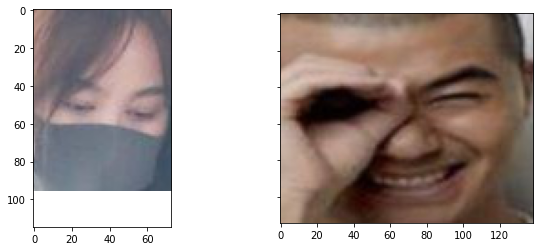

In [12]:
mask_path = os.path.join(base_dir, cls[0], '*')
mask = glob.glob(mask_path)
mask = io.imread(mask[0])

wmask_path = os.path.join(base_dir, cls[1], '*')
wmask = glob.glob(wmask_path)
wmask = io.imread(wmask[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)

axes[0].imshow(mask, cmap='gray')
axes[1].imshow(wmask, cmap='gray')

In [6]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

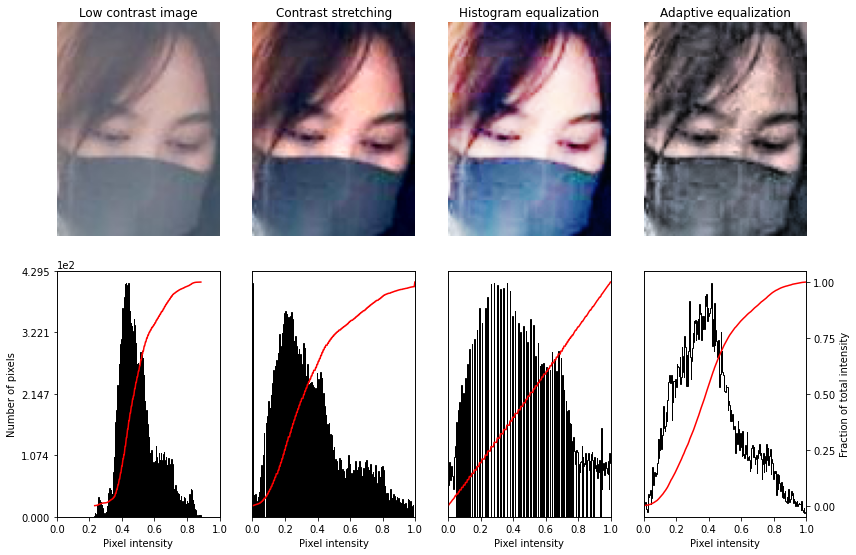

In [13]:
img = mask

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

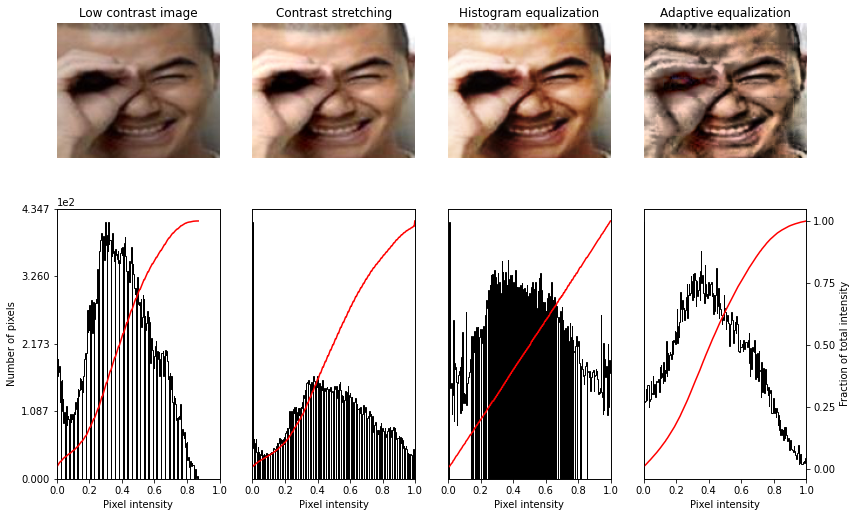

In [14]:
img = wmask

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [15]:
base_dir = '/content/drive/MyDrive/Machine Learning/Tubes/Splited Dataset'

train_dir = os.path.join(base_dir, 'train')
mask_train_dir = os.path.join(train_dir, 'with_mask')
wmask_train_dir = os.path.join(train_dir, 'without_mask')

val_dir = os.path.join(base_dir, 'val')
mask_val_dir = os.path.join(val_dir, 'with_mask')
wmask_val_dir = os.path.join(val_dir, 'without_mask')

In [16]:
print("Total Training with_mask:", len(os.listdir(mask_train_dir)))
print("Total Training without_mask:", len(os.listdir(wmask_train_dir)))
print()
print("Total validation with_mask:", len(os.listdir(mask_val_dir)))
print("Total validation without_mask:", len(os.listdir(wmask_val_dir)))

Total Training with_mask: 1732
Total Training without_mask: 1544

Total validation with_mask: 411
Total validation without_mask: 366


In [17]:
def gather_data(data_dir):
    dir_data = []
    dir_label = []

    for dirpath, dirnames, filenames in os.walk(data_dir):
        for file in filenames:
            if ".jpeg" in file:
                image_path = os.path.join(dirpath, file)

                image = cv2.imread(image_path)
                image = cv2.resize(image, (150,150))
                image = image.astype('float32') / 255.0
                dir_data.append(image)

                label = int((image_path.split(os.path.sep)[-2]) == 'with_mask')
                dir_label.append(label)

    dir_data = np.array(dir_data)
    dir_label = np.array(dir_label)

    return dir_data, dir_label

In [18]:
x_train, y_train = gather_data(train_dir)
x_val, y_val = gather_data(val_dir)

In [21]:
gather_save = '/content/drive/MyDrive/Machine Learning/Tubes/GatherData'

In [22]:
preprocessed_data = [x_train, y_train, x_val, y_val]
preprocessed_file_name = ['x_train', 'y_train', 'x_val', 'y_val']
for i, file_name in enumerate(preprocessed_file_name):
    np.save(gather_save + '/' + file_name + '.npy', preprocessed_data[i])

In [23]:
import numpy as np

In [24]:
x_train = np.load(gather_save + '/x_train.npy')
y_train = np.load(gather_save + '/y_train.npy')

x_val = np.load(gather_save + '/x_val.npy')
y_val = np.load(gather_save + '/y_val.npy')

In [25]:
print("Train Data = ", x_train.shape)
print("Train Label = ", y_train.shape)
print()
print("Val Data = ", x_val.shape)
print("Val Label = ", y_val.shape)

Train Data =  (70, 150, 150, 3)
Train Label =  (70,)

Val Data =  (24, 150, 150, 3)
Val Label =  (24,)


In [26]:
from skimage.io import imread
from skimage.transform import resize

In [27]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block

In [28]:
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [29]:
def build_model():
    model = Sequential([
        Input(shape=(150, 150, 3)),

        Conv2D(16, 3, activation='relu', padding='same'),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        Dropout(0.2),
        
        conv_block(256),
        
        Dropout(0.2),
        Flatten(),
        
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [30]:
base_dir = '/content/drive/MyDrive/Machine Learning/Tubes/Dataset'

In [31]:
mask_dir = os.path.join(base_dir, 'with_mask')
wmask_dir = os.path.join(base_dir, 'without_mask')

print("Total Training with_mask:", len(os.listdir(mask_dir)))
print("Total Training without_mask:", len(os.listdir(wmask_dir)))

Total Training with_mask: 2165
Total Training without_mask: 1930


In [32]:
mask_data_count = len(os.listdir(mask_dir))
wmask_data_count = len(os.listdir(wmask_dir))

print(f"Jumlah with_mask: {mask_data_count}\nJumlah without_mask: {wmask_data_count}")

Jumlah with_mask: 2165
Jumlah without_mask: 1930


In [33]:
weight_for_0 = (1 / mask_data_count) * (x_train.shape[0]) / 2.0 
weight_for_1 = (1 / wmask_data_count) * (x_train.shape[0]) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.02
Weight for class 1: 0.02


In [61]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, InputLayer, MaxPool2D, SeparableConv2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [66]:
train_dir = '/content/drive/MyDrive/Machine Learning/Tubes/Splited Dataset/train'
val_dir = '/content/drive/MyDrive/Machine Learning/Tubes/Splited Dataset/val'
test_dir = '/content/drive/MyDrive/Machine Learning/Tubes/Splited Dataset/test'

In [67]:
batch_size = 20

In [74]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.5,
    fill_mode='constant',
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100,150),
    batch_size = batch_size,
    shuffle=True,
    color_mode="rgb",
    class_mode='categorical'
)

val_gen = train_datagen.flow_from_directory(
    val_dir,
    target_size=(100,150),
    batch_size = batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,150),
    batch_size = batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

Found 3273 images belonging to 2 classes.
Found 777 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [69]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flaten
    tf.keras.layers.Flatten(),
    #batch normalization
    tf.keras.layers.BatchNormalization(),
    #dropout
    tf.keras.layers.Dropout(0.5, input_shape=(2,)),
    #fully connected
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')                                 
])
model2.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 49, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 47, 72, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 23, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 34, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 10, 17, 128)    

In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [79]:
# setting Callback so we can save the best model in format h5 and i save it in my drive
callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
dir = '/content/drive/MyDrive/Machine Learning/Tubes/Model/best_model_train_cnn.h5'
best_model = ModelCheckpoint(dir, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [80]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
]

model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',      
              metrics=METRICS)

In [81]:
history = model2.fit_generator(train_gen, steps_per_epoch=10, epochs=100, validation_data= val_gen, validation_steps=4, verbose=1, callbacks=[callbacks, best_model])

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.8000 - precision: 0.7674 - recall: 0.8250
Epoch 00001: val_accuracy improved from -inf to 0.49500, saving model to /content/drive/MyDrive/Machine Learning/Tubes/Model/best_model_train_cnn.h5
10/10 [==============================] - 85s 9s/step - loss: 0.5761 - accuracy: 0.8000 - precision: 0.7674 - recall: 0.8250 - val_loss: 0.6954 - val_accuracy: 0.4950 - val_precision: 0.4950 - val_recall: 0.4950
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8900 - precision: 0.8824 - recall: 0.9000
Epoch 00002: val_accuracy did not improve from 0.49500
10/10 [==============================] - 68s 7s/step - loss: 0.2815 - accuracy: 0.8900 - precision: 0.8824 - recall: 0.9000 - val_loss: 0.6992 - val_accuracy: 0.4850 - val_precision: 0.4850 - val_recall: 0.4850
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8550 - precision: 0.

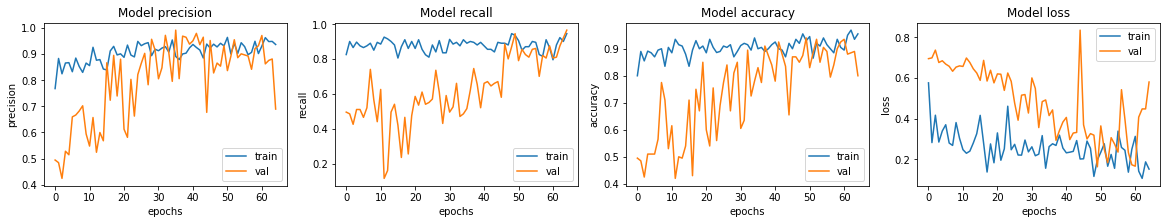

In [82]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [86]:
loss, acc, prec, rec = model2.evaluate(test_gen)
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

3/3 [==============================] - 11s 5s/step - loss: 0.2363 - accuracy: 0.9286 - precision: 0.6885 - recall: 1.0000
Accuracy = 92.86 %
Precision = 68.85 %
Recall = 100.00 %
